Notebook derived from Behavior_Analysis_2

# Visualizing the mouse behavior

In [51]:
import sys
sys.path.append('/Users/celia/GitHub/mouse_bandit/data_preprocessing_code')
sys.path.append('/Users/celia/GitHub/mouse_bandit')
import support_functions as sf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy as sp
import bandit_preprocessing as bp
import sklearn.linear_model
from sklearn import discriminant_analysis
from sklearn import model_selection
from sklearn import tree as Tree
import sklearn.tree
import sys
import os
%matplotlib inline 

## load in csv files (from running exportTrials.m)

In [12]:
data_blocks = pd.read_csv('/Users/celia/GitHub/mouse_bandit/data/processed_data/master_data.csv')
data_blocks['Block ID']= 'NaN' # Create new columns for dataframe
data_blocks['Current Block Length'] = 'NaN'
data=data_blocks.copy()

In [98]:
data = pd.read_csv('/Users/celia/GitHub/mouse_bandit/data/processed_data/markov_9010_df.csv')
len(np.unique(data['Session ID']))

75

In [52]:
data = pd.read_csv('/Users/celia/GitHub/mouse_bandit/data/processed_data/markov_master_df.csv')
data['Block ID']= 'NaN' # Create new columns for dataframe
data['Current Block Length'] = 'NaN'

In [53]:
data.shape # number of trials by number of days

(79165, 56)

In [54]:
data.head(2)

,Unnamed: 0,Mouse ID,Session ID,Trial,Block Trial,Block Reward,Port Streak,Reward Streak,10_Port,10_Reward,...,1_ITI,1_trialDuration,0_ITI,0_trialDuration,Decision,Switch,Higher p port,Reward,Block ID,Current Block Length
0,0,Baby,08242017_Baby,11.0,11.0,7.0,1.0,-1.0,1.0,0.0,...,1.088,0.491,30.031,0.429,0.0,1.0,1.0,1.0,NaN,NaN
1,1,Baby,08242017_Baby,12.0,12.0,8.0,1.0,1.0,0.0,1.0,...,30.031,0.429,7.028,0.506,0.0,0.0,1.0,1.0,NaN,NaN


In [55]:
record_path = '/Users/celia/GitHub/mouse_bandit/session_record.csv' # session record of behavioral data
record = pd.read_csv(record_path,index_col=0) # session record is panda df

In [56]:
'''Initialize paths and import data'''

record_path = '/Users/celia/GitHub/mouse_bandit/celia_session_record.csv' # session record of behavioral data
record = pd.read_csv(record_path,index_col=0) # session record is panda df

In [57]:
np.unique(data['Reward Streak']) # all the different reward streaks across all trials

array([-19., -18., -17., -16., -15., -14., -13., -12., -11., -10.,  -9.,
        -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   1.,   2.,   3.,
         4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,  14.,
        15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,  25.,
        26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,  36.,
        37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,
        48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.])

In [58]:
data[data['Reward Streak'] == 0]['Switch'].mean() #why was there a value for this before and not now? goes from 1 to -1

nan

### Add column for block ID number within current day and column for current block length

In [59]:
columns = ['Elapsed Time (s)','Since last trial (s)','Trial Duration (s)','Port Poked',
           'Right Reward Prob','Left Reward Prob','Reward Given',
          'center_frame','decision_frame', 'Block ID']

for session in np.unique(data['Session ID'])[:]:
    
    # load in data from a particular session
    record[record['Session ID'] == session] # take only rows from record that match session name
    root_dir = '/Users/celia/GitHub/mouse_bandit/data/trial_data'
    full_name = session + '_trials.csv'
    path_name = os.path.join(root_dir,full_name)
    trial_df = pd.read_csv(path_name,names=columns) # load in full dataset from a single trial
    
    # determine block lengths and attach block id to each trial
    # identify blocks by trials where right reward probability changes
    blocks = list(np.diff(np.concatenate((range(1),np.where(np.diff(trial_df['Right Reward Prob']) != 0)[0]+2))))
    
    try: 
        #np.where(np.diff(trial_df['Right Reward Prob']) != 0)[0][-1]
        blocks.append(int(record[record['Session ID']==session]['No. Trials'].values)
                 -np.where(np.diff(trial_df['Right Reward Prob']) != 0)[0][-1]-1) # length of the last block at end
        block_id = np.asarray([x+1 for x in range(int(record[record['Session ID']==session]['No. Blocks'].values[0])+1)
            for y in range(blocks[x])])

        trial_df['Block ID'] = block_id[:-1] # add column in trial_df for block id
        
        # add block id and current block length to dataframe
        data.loc[data[data['Session ID']==session].index, 'Block ID'] = block_id[11:]
        temp = [blocks[x-1] for x in block_id[11:]]
        data.loc[data[data['Session ID']==session].index, 'Current Block Length'] = temp
    
    except IndexError: # report any errors - days when no blocks were completed
        print('No blocks in %s' %session)

data.head(5)

,Unnamed: 0,Mouse ID,Session ID,Trial,Block Trial,Block Reward,Port Streak,Reward Streak,10_Port,10_Reward,...,1_ITI,1_trialDuration,0_ITI,0_trialDuration,Decision,Switch,Higher p port,Reward,Block ID,Current Block Length
0,0,Baby,08242017_Baby,11.0,11.0,7.0,1.0,-1.0,1.0,0.0,...,1.088,0.491,30.031,0.429,0.0,1.0,1.0,1.0,1,38
1,1,Baby,08242017_Baby,12.0,12.0,8.0,1.0,1.0,0.0,1.0,...,30.031,0.429,7.028,0.506,0.0,0.0,1.0,1.0,1,38
2,2,Baby,08242017_Baby,13.0,13.0,9.0,2.0,2.0,1.0,0.0,...,7.028,0.506,1.690,0.345,0.0,0.0,1.0,1.0,1,38
3,3,Baby,08242017_Baby,14.0,14.0,10.0,3.0,3.0,0.0,1.0,...,1.690,0.345,1.608,0.561,0.0,0.0,1.0,1.0,1,38
4,4,Baby,08242017_Baby,15.0,15.0,11.0,4.0,4.0,0.0,1.0,...,1.608,0.561,4.804,0.311,0.0,0.0,1.0,1.0,1,38


### Look at different features based on binned block lengths (really short vs really long, vs average ~50)

In [60]:

data_match_blocks = data[data['Current Block Length']<90] # take only blocks with fewer than 90 trials
data_match_blocks = data_match_blocks[data_match_blocks['Current Block Length']>50] # blocks with 30+ trials
data = data_match_blocks.copy()


In [61]:
data.shape

(22802, 56)

(array([ 2898.,  2313.,  2265.,  2206.,  1860.,  2311.,  1871.,  2659.,
         2087.,  2332.]),
 array([ 51. ,  54.8,  58.6,  62.4,  66.2,  70. ,  73.8,  77.6,  81.4,
         85.2,  89. ]),
 <a list of 10 Patch objects>)

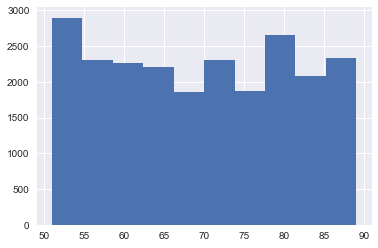

In [62]:
plt.hist(data['Current Block Length'])

## separate back into individual days
Something about this may not be working quite right

In [63]:
data_mustard = data[data['Mouse ID'] == 'Mustard']
data_raspberry = data[data['Mouse ID'] == 'Raspberry']
data_baby = data[data['Mouse ID'] == 'Baby']
data_sky = data[data['Mouse ID'] == 'Sky']
data_wine = data[data['Mouse ID']=='Wine']
datas = []

for s in np.unique(data['Session ID']):
    datas.append(data_mustard[data_mustard['Session ID']==s])
    datas.append(data_sky[data_sky['Session ID']==s])
    datas.append(data_baby[data_baby['Session ID']==s])
    datas.append(data_raspberry[data_raspberry['Session ID']==s])
    datas.append(data_wine[data_wine['Session ID']==s])

# clean up empty rows that got added - not necessary before?
count = 0
for i in range(len(datas)):
    if datas[count].values.shape[0] == 0:
        del datas[count]
    else:
        count +=1

n_sessions = len(datas)

# p(switch) | switched in ith previous trial
    -where the animal had a 'switch' trial, track back up to 20 steps
    -at i=0, switch = 1; past that, probability of switch changes (calculated by mean)
    -probability calculated for all aligned events -- ex: p_switch at 1 step before switch across all switch events
    -Resulting array has 20 values representing the 20 time points leading up to a switch, for which the probability of switching is calculated by the number of switches in each time bin divided by the total number of data points in the time bin

In [64]:
# for data in pandas dataframe (original dataset)
n_steps_back = 20
p_switch = np.zeros(n_steps_back)
for i in np.arange(0,n_steps_back):
    p_switch[i] = data.iloc[np.where(data['Switch'].values == 1)[0]-i]['Switch'].mean(axis=0)

In [65]:
# for data in the form of a list (subset of dataset)
p_switchy = np.zeros((len(datas),n_steps_back)) #to stack switch probabilities across different sessions

for s,d in enumerate(datas):
    for i in np.arange(0,n_steps_back):
        p_switchy[s,i] = d.iloc[np.where(d['Switch'].values == 1)[0]-i]['Switch'].mean(axis=0)

In [66]:
len(datas)

111

In [67]:
errors = p_switchy.std(axis=0) / np.sqrt(len(p_switchy))

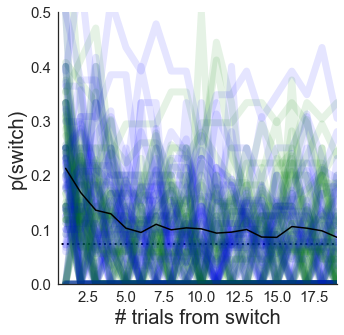

In [68]:
sns.set_style('white')
plt.figure(figsize=(5,5))
for mice in range(n_sessions):
    if (mice%2 == 0):
        plt.plot(np.arange(1,n_steps_back),p_switchy[mice,1:],alpha=0.1,linewidth=7,color='blue')
    else:
        plt.plot(np.arange(1,n_steps_back),p_switchy[mice,1:],alpha=0.1,linewidth=7,color='green')
        
plt.hlines(y=data['Switch'].mean(axis=0),xmin=0,xmax=n_steps_back,color='black',alpha=1,linewidth=2,linestyles='dotted',label='average')
plt.plot(np.arange(1,n_steps_back),p_switch[1:],color='black',linewidth=1.5)
plt.fill_between(np.arange(1,n_steps_back),p_switch[1:]+errors[1:],p_switch[1:]-errors[1:],color='grey')
plt.xlim(0.5,19)
plt.ylim(0,0.5)
plt.xlabel('# trials from switch',fontsize=20)
plt.ylabel('p(switch)',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
sns.despine()

# Looking more closely at the switch trials

In [69]:
switches = data['Switch'].values

In [70]:
streak = np.array([3,2,1,-1,-2,-3,-4,-5,-6,-7,-8])
port_streaks = np.arange(0,6)
p_switch_a = np.zeros_like(streak)*0.0
p_switch_b = np.zeros_like(streak)*0.0

for i,s in enumerate(streak): 
        p_switch_a[i] = data[(data['Port Streak'] >= 5) & (data['Reward Streak'] == s)]['Switch'].mean()
        p_switch_b[i] = data[(data['Port Streak'] < 5) & (data['Reward Streak'] == s)]['Switch'].mean()

In [71]:
streak = np.array([3,2,1,-1,-2,-3,-4,-5,-6,-7,-8])
port_streaks = np.arange(0,6)
p_switch_indi_a = np.zeros((len(datas),streak.shape[0]))
p_switch_indi_b = np.zeros_like(p_switch_indi_a)

for j,d in enumerate(datas):
    for i,s in enumerate(streak): 
            p_switch_indi_a[j,i] = d[(d['Port Streak'] >= 5) & (d['Reward Streak'] == s)]['Switch'].mean()
            p_switch_indi_b[j,i] = d[(d['Port Streak'] < 5) & (d['Reward Streak'] == s)]['Switch'].mean()

In [72]:
errors_a = np.nanstd(p_switch_indi_a,axis=0) / np.sqrt(p_switch_indi_a.shape[0])
errors_b = np.nanstd(p_switch_indi_b,axis=0) / np.sqrt(p_switch_indi_a.shape[0])

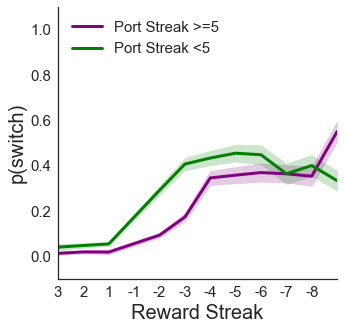

In [73]:
plt.figure(figsize=(5,5))
#plt.vlines(x=0,ymin=0,ymax=1,color='white',linewidth=60,zorder=3)
plt.plot(streak,p_switch_a,label='Port Streak >=5',linewidth=3,zorder=1,color='purple')
plt.fill_between(streak,p_switch_a+errors_a,p_switch_a-errors_a,color='purple',alpha=0.2)
plt.plot(streak,p_switch_b,label='Port Streak <5',linewidth=3,zorder=2,color='green')
plt.fill_between(streak,p_switch_b+errors_b,p_switch_b-errors_b,color='green',alpha=0.2)
plt.xticks(np.arange(3,-8,-1),streak,fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(3,-8)
plt.ylim(-0.1,1.1)
plt.legend(loc='upper left',fontsize=15)
sns.despine()
plt.ylabel('p(switch)',fontsize=20)
plt.xlabel('Reward Streak',fontsize=20)

# Switches when 1_Reward = 0

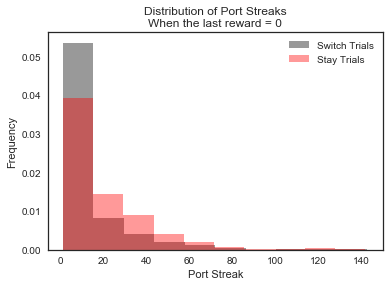

In [74]:
plt.hist(data[(data['1_Reward'] == 0) & (data['Switch'] == 1)]['Port Streak'],color='black',alpha=0.4,normed=True,label='Switch Trials')
plt.hist(data[(data['1_Reward'] == 0) & (data['Switch'] == 0)]['Port Streak'],color='red',alpha=0.4,normed=True,label='Stay Trials')
plt.title('Distribution of Port Streaks\nWhen the last reward = 0')
plt.ylabel('Frequency')
plt.xlabel('Port Streak')
plt.legend(loc='upper right')
#plt.xlim(0,max(data['Port Streak'].values))
#plt.ylim(0,0.1)


(array([  3.65110677e-02,   1.62241591e-02,   9.52112563e-03,
          5.24701920e-03,   2.18737629e-03,   7.51491240e-04,
          1.54324094e-04,   9.39364051e-05,   1.57678966e-04,
          7.38071754e-05]),
 array([   1. ,   15.1,   29.2,   43.3,   57.4,   71.5,   85.6,   99.7,
         113.8,  127.9,  142. ]),
 <a list of 10 Patch objects>)

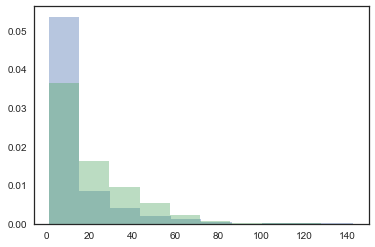

In [75]:
plt.hist(data[data['Switch']==1]['Port Streak'],normed=True,alpha=0.4)
plt.hist(data[data['Switch']==0]['Port Streak'],normed=True,alpha=0.4)

(array([  3.65110677e-02,   1.62241591e-02,   9.52112563e-03,
          5.24701920e-03,   2.18737629e-03,   7.51491240e-04,
          1.54324094e-04,   9.39364051e-05,   1.57678966e-04,
          7.38071754e-05]),
 array([   1. ,   15.1,   29.2,   43.3,   57.4,   71.5,   85.6,   99.7,
         113.8,  127.9,  142. ]),
 <a list of 10 Patch objects>)

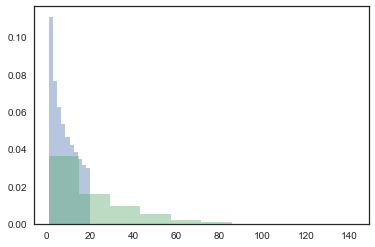

In [76]:
plt.hist(data[data['Port Streak'] <= 20]['Port Streak'],normed=True,alpha=0.4)
plt.hist(data[data['Switch']==0]['Port Streak'],normed=True,alpha=0.4)

In [77]:
data[data['Port Streak'] > 5]['Switch'].mean()

0.04578884934756821

In [78]:
p_switch

array([ 1.        ,  0.21239471,  0.16787004,  0.13537906,  0.12876053,
        0.1022864 ,  0.0944645 ,  0.10950662,  0.09927798,  0.10288809,
        0.10108303,  0.09326113,  0.09506619,  0.09987966,  0.08604091,
        0.08543923,  0.10529483,  0.1022864 ,  0.09747292,  0.08543923])

In [79]:
n_steps_back=10
p_switch = np.zeros(n_steps_back)
avg = data['Switch'].mean()

for i,s in enumerate(np.arange(1,n_steps_back+1)):
    p_switch[i] = data[data['Port Streak'] == s]['Switch'].mean()

p_switches = np.zeros((n_sessions,n_steps_back))
p_switches_R = np.zeros((n_sessions,n_steps_back))
p_switches_nR = np.zeros((n_sessions,n_steps_back))
for j,d in enumerate(datas):
    for i,s in enumerate(np.arange(1,n_steps_back+1)):
        p_switches[j,i] = d[d['Port Streak'] == s]['Switch'].mean()
        p_switches_R[j,i] = d[(d['Port Streak'] == s) & (d['1_Reward']==1)]['Switch'].mean()
        p_switches_nR[j,i] = d[(d['Port Streak'] == s) & (d['1_Reward']==0)]['Switch'].mean()

errors = p_switches.std(axis=0) / np.sqrt(p_switches.shape[0])
errors_R = np.nanstd(p_switches_R,axis=0) / np.sqrt(p_switches.shape[0])
errors_nR = np.nanstd(p_switches_nR,axis=0) / np.sqrt(p_switches.shape[0])
p_switch_R = np.nanmean(p_switches_R,axis=0)
p_switch_nR = np.nanmean(p_switches_nR,axis=0)

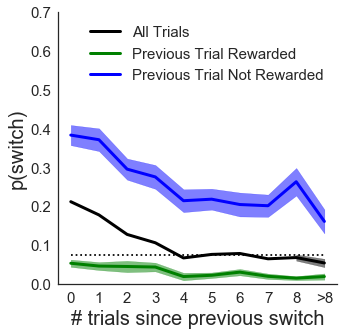

In [80]:
plt.figure(figsize=(5,5))

plt.plot(np.arange(1,n_steps_back+1),p_switch,color='black',linewidth=3,label='All Trials')
plt.fill_between(np.arange(1,n_steps_back+1),p_switch+errors,p_switch-errors,color='black',alpha=0.5)

plt.plot(np.arange(1,n_steps_back+1),p_switch_R,color='green',linewidth=3,label='Previous Trial Rewarded')
plt.fill_between(np.arange(1,n_steps_back+1),p_switch_R+errors_R,p_switch_R-errors_R,color='green',alpha=0.5)

plt.plot(np.arange(1,n_steps_back+1),p_switch_nR,color='blue',linewidth=3,label='Previous Trial Not Rewarded')
plt.fill_between(np.arange(1,n_steps_back+1),p_switch_nR+errors_nR,p_switch_nR-errors_nR,color='blue',alpha=0.5)

plt.hlines(y=avg,xmin=1,xmax=10,linestyle='dotted')
plt.ylim(0,0.7)
plt.ylabel('p(switch)',fontsize=20)
plt.xlabel('# trials since previous switch',fontsize=20)
plt.legend(loc='upper right',fontsize=15)
plt.xticks(np.arange(1,11),[0,1,2,3,4,5,6,7,8,'>8','>9'],fontsize=15)
plt.yticks(fontsize=15)
sns.despine()

In [81]:
c = 0
cs = np.zeros(n_steps_back)
for j,i in enumerate(np.arange(1,n_steps_back+1)):
    c +=  data[data['Port Streak'] == i]['Switch'].sum()/data['Switch'].sum()
    cs[j] = c

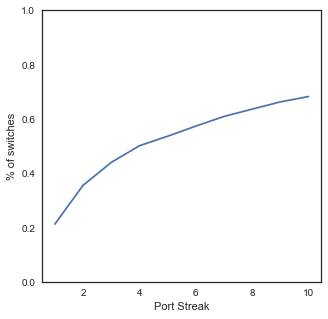

In [82]:
plt.figure(figsize=(5,5))
plt.plot(np.arange(1,11),cs)
plt.ylim(0,1)
plt.ylabel('% of switches')
plt.xlabel('Port Streak')

In [83]:
t_block_unique = np.unique(data['Block Trial'].values)
p_switch_block = np.zeros((t_block_unique.shape[0],2))
high_p_port = np.zeros_like(p_switch_block)
trial_block_count = np.zeros_like(t_block_unique)

for t in t_block_unique:
    t=int(t)
    p_switch_block[t,0] = data[data['Block Trial'] == t]['Switch'].mean(axis=0)
    trial_block_count[t] = data[data['Block Trial'] == t].shape[0]
    p_switch_block[t,1] = data[data['Block Trial'] == t]['Switch'].std(axis=0) / np.sqrt(trial_block_count[t])
    
    high_p_port[t,0] = data[data['Block Trial']==t]['Higher p port'].mean(axis=0)
    high_p_port[t,1] = data[data['Block Trial']==t]['Higher p port'].std(axis=0) / np.sqrt(trial_block_count[t])
    

total # of blocks in dataset: ~312


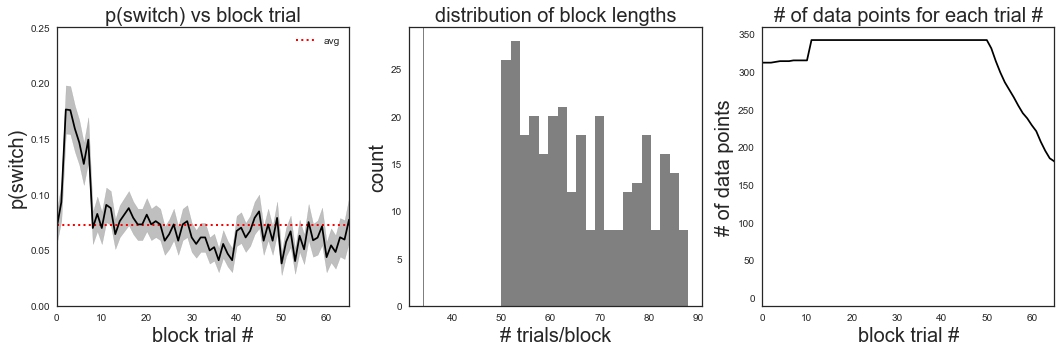

In [89]:
x_end=65
plt.figure(figsize=(15,5))
#plt.suptitle('analysis of blocks where probabilities switched every 50 rewards',x=0.5,y=1.1,fontsize=20)

plt.subplot(131)
plt.plot(t_block_unique,p_switch_block[:,0],color='black')
plt.fill_between(t_block_unique,p_switch_block[:,0]+p_switch_block[:,1],p_switch_block[:,0]-p_switch_block[:,1],color='grey',alpha=0.5)
plt.hlines(data['Switch'].mean(axis=0),xmin=0,xmax=x_end,color='red',linestyle='dotted',label='avg',linewidth=2)
plt.legend(loc='upper right')
plt.xlim(0,x_end)
plt.ylim(0,0.25)
plt.xlabel('block trial #',fontsize=20)
plt.ylabel('p(switch)',fontsize=20)
plt.title('p(switch) vs block trial',fontsize=20)

plt.subplot(132)
plt.hist(data.iloc[np.where(data['Block Trial']==0)[0]-1]['Block Trial'],bins=20,color='grey')
plt.title('distribution of block lengths',fontsize=20)
plt.xlabel('# trials/block',fontsize=20)
plt.ylabel('count',fontsize=20)
plt.axvline(x = data['Block Trial'].median(), color='black', linewidth=0.5)

plt.subplot(133)
plt.plot(t_block_unique,trial_block_count,color='black')
plt.title('# of data points for each trial #',fontsize=20)
plt.ylabel('# of data points',fontsize=20)
plt.xlabel('block trial #',fontsize=20)
plt.xlim(0,x_end)

plt.tight_layout()
print('total # of blocks in dataset: ~%.0f' % (np.sum(data['Block Trial']==0)))

In [85]:
data.index = np.arange(data.shape[0])

In [86]:
switch_points = data[data['Block Trial'] == 0 ].index.values

In [93]:
data

,Unnamed: 0,Mouse ID,Session ID,Trial,Block Trial,Block Reward,Port Streak,Reward Streak,10_Port,10_Reward,...,1_ITI,1_trialDuration,0_ITI,0_trialDuration,Decision,Switch,Higher p port,Reward,Block ID,Current Block Length
0,87,Baby,08242017_Baby,98.0,0.0,19.0,8.0,8.0,1.0,1.0,...,6.115,0.424,3.521,0.554,0.0,0.0,0.0,0.0,4,63
1,88,Baby,08242017_Baby,99.0,1.0,0.0,9.0,-1.0,1.0,0.0,...,3.521,0.554,1.320,0.502,0.0,0.0,0.0,0.0,4,63
2,89,Baby,08242017_Baby,100.0,2.0,0.0,10.0,-2.0,0.0,1.0,...,1.320,0.502,2.810,0.557,1.0,1.0,1.0,1.0,4,63
3,90,Baby,08242017_Baby,101.0,3.0,1.0,1.0,1.0,0.0,1.0,...,2.810,0.557,7.040,0.531,1.0,0.0,1.0,1.0,4,63
4,91,Baby,08242017_Baby,102.0,4.0,2.0,2.0,2.0,0.0,1.0,...,7.040,0.531,5.442,0.383,1.0,0.0,1.0,1.0,4,63
5,92,Baby,08242017_Baby,103.0,5.0,3.0,3.0,3.0,0.0,1.0,...,5.442,0.383,5.315,0.476,1.0,0.0,1.0,1.0,4,63
6,93,Baby,08242017_Baby,104.0,6.0,4.0,4.0,4.0,0.0,1.0,...,5.315,0.476,1.436,0.460,0.0,1.0,0.0,0.0,4,63
7,94,Baby,08242017_Baby,105.0,7.0,4.0,1.0,-1.0,0.0,1.0,...,1.436,0.460,1.590,0.557,1.0,1.0,1.0,1.0,4,63
8,95,Baby,08242017_Baby,106.0,8.0,5.0,1.0,1.0,0.0,1.0,...,1.590,0.557,5.006,0.485,1.0,0.0,1.0,1.0,4,63
9,96,Baby,08242017_Baby,107.0,9.0,6.0,2.0,2.0,0.0,1.0,...,5.006,0.485,6.273,0.592,1.0,0.0,1.0,1.0,4,63


In [87]:
switch_points = data[data['Block Trial'] == 0 ].index.values

L = 15
paraswitch = np.zeros((switch_points.shape[0],L*2 + 10))
paraswitch_port = np.zeros_like(paraswitch)

for i,point in enumerate(switch_points):
    if data.iloc[-1]['Trial'] - data.iloc[point]['Trial'] > L+10:
        paraswitch[i,:] = data.iloc[point-L:point+L+10]['Switch']
        paraswitch_port[i,:] = data.iloc[point-L:point+L+10]['Higher p port'] 

ValueError: could not broadcast input array from shape (0) into shape (40)

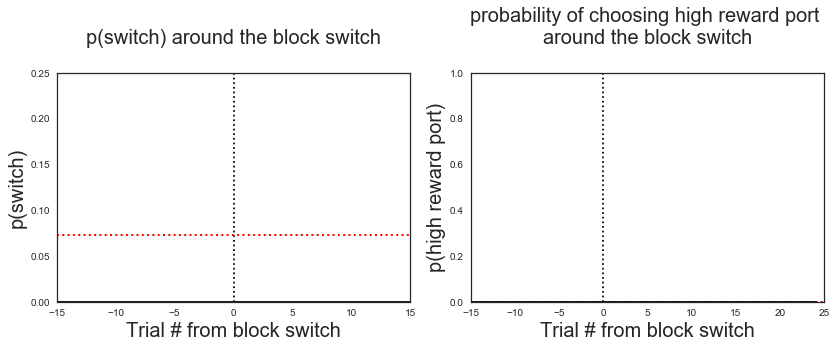

In [88]:
u = paraswitch.mean(axis=0)
s = paraswitch.std(axis=0)
SE = s/np.sqrt(paraswitch.shape[0])
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.plot(np.arange(-1*L,L+10),u,color='black')
plt.fill_between(np.arange(-1*L,L+10),u+SE,u-SE,color='grey',alpha=0.5)
plt.vlines(x=0,ymin=0,ymax=0.5,color='black',linestyle='dotted')
plt.hlines(data['Switch'].mean(axis=0),xmin=-1*L,xmax=L+1,color='red',linestyle='dotted',label='avg',linewidth=2)
plt.xlabel('Trial # from block switch',fontsize=20)
plt.ylabel('p(switch)',fontsize=20)
plt.title('p(switch) around the block switch',fontsize=20,x=0.5,y=1.1)
plt.xlim(-1*L,L)
plt.ylim(0,0.25)

plt.subplot(122)
u = paraswitch_port.mean(axis=0)
s = paraswitch_port.std(axis=0)
SE = s/np.sqrt(paraswitch.shape[0])
plt.plot(np.arange(-1*L,L+10),u,color='black')
plt.fill_between(np.arange(-1*L,L+10),u+SE,u-SE,color='grey',alpha=0.5)
plt.vlines(x=0,ymin=0,ymax=1,color='black',linestyle='dotted')
plt.hlines(np.median(u),xmin=-1*L,xmax=L+10,color='red',linestyle='dotted',label='avg',linewidth=2)
plt.xlabel('Trial # from block switch',fontsize=20)
plt.ylabel('p(high reward port)',fontsize=20)
plt.title('probability of choosing high reward port \naround the block switch',fontsize=20,x=0.5,y=1.1)
plt.xlim(-1*L,L+10)
plt.ylim(0,1)

plt.tight_layout()

(0, 1)

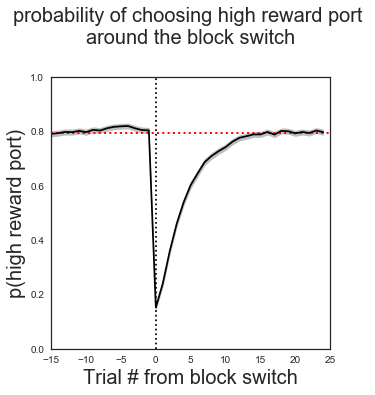

In [308]:
u = paraswitch_port.mean(axis=0)
s = paraswitch_port.std(axis=0)
SE = s/np.sqrt(paraswitch.shape[0])
plt.figure(figsize=(5,5))
plt.plot(np.arange(-1*L,L+10),u,color='black')
plt.fill_between(np.arange(-1*L,L+10),u+SE,u-SE,color='grey',alpha=0.5)
plt.vlines(x=0,ymin=0,ymax=1,color='black',linestyle='dotted')
plt.hlines(np.median(u),xmin=-1*L,xmax=L+10,color='red',linestyle='dotted',label='avg',linewidth=2)
plt.xlabel('Trial # from block switch',fontsize=20)
plt.ylabel('p(high reward port)',fontsize=20)
plt.title('probability of choosing high reward port \naround the block switch',fontsize=20,x=0.5,y=1.1)
plt.xlim(-1*L,L+10)
plt.ylim(0,1)

In [309]:
switch_points = data[data['Block Trial'] == 0 ].index.values

little note on the for loop below. 

took me little while because I had the order of the else-if statements wrong. 

when block_trial == 0 needs to come BEFORE whether the block trial incremented by 1 or not (which is my hokey way of detecting when a new session started where block_trial does not equal 0. 

I suppose a better way would be to detect when the block trial is 11 AND the previous block trial != 10. that would work. okay. switched it to that now. 

In [310]:
block_reward = np.zeros(data.shape[0])
for i in range(data.shape[0]):
    trial = data.iloc[i]
    
    #lets deal with weird cases first:
    #1) the first row
    if(i == 0):
        block_reward[i] = trial[['10_Reward','9_Reward','8_Reward','7_Reward','6_Reward',
                                '5_Reward','4_Reward','3_Reward','2_Reward','1_Reward','Reward']].sum()
    
    #3) the first trial of a new block
    elif (trial['Block Trial'] == 0):
        block_reward[i] = 0
    
    #2) the first trial of a new session
    elif (((trial['Block Trial'] - trial_prev['Block Trial']) != 1) and (trial['Block Trial'] == 11)):
        block_reward[i] = trial[['10_Reward','9_Reward','8_Reward','7_Reward','6_Reward',
                                '5_Reward','4_Reward','3_Reward','2_Reward','1_Reward','Reward']].sum()
    else:
        block_reward[i] = block_reward[i-1] + trial['Reward']
    
    trial_prev = trial

In [311]:
reward_switches = np.zeros(np.unique(block_reward).shape[0])
reward_switches_afterR = np.zeros(np.unique(block_reward).shape[0])
reward_switches_afterNoR = np.zeros(np.unique(block_reward).shape[0])
for i,r_block in enumerate(np.unique(block_reward)):
    reward_switches[i] = data[block_reward == r_block]['Switch'].mean()
    reward_switches_afterR[i] = data[((block_reward == r_block) & (data['1_Reward']==1))]['Switch'].mean()
    reward_switches_afterNoR[i] = data[((block_reward == r_block) & (data['1_Reward']==0))]['Switch'].mean()

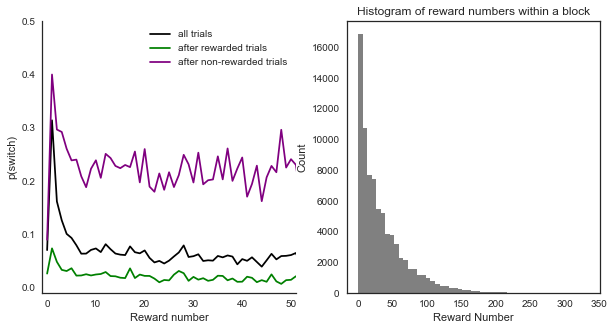

In [312]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(np.unique(block_reward),reward_switches,color='black',label='all trials')
plt.plot(np.unique(block_reward),reward_switches_afterR,color='green',label='after rewarded trials')
plt.plot(np.unique(block_reward),reward_switches_afterNoR,color='purple',label='after non-rewarded trials')
plt.xlabel('Reward number')
plt.ylabel('p(switch)')
plt.legend(loc='upper right')
plt.xlim(-1,51)
plt.ylim(-0.01,0.5)
sns.despine()

plt.subplot(122)
plt.hist(block_reward,bins=51,color='grey')
plt.title('Histogram of reward numbers within a block')
plt.xlabel('Reward Number')
plt.ylabel('Count')

### # of switches after a block change
    switch_points are points when block switches

In [313]:
n_steps_forward = 10
switch_after_transition = np.zeros((n_steps_forward, len(switch_points)))
switch_before_transition = np.zeros((n_steps_forward, len(switch_points)))

for i,trial in enumerate(switch_points):
    switch_after_transition[:,i] = data.loc[trial:trial+n_steps_forward-1, 'Switch'].values

for i,trial in enumerate(switch_points):
    switch_before_transition[:,i] = data.loc[trial-n_steps_forward-1:trial:trial, 'Switch'].values 

mean_switches_after = np.mean(switch_after_transition.sum(axis=0)) # mean number of switches in first 10 trials after block switch
mean_switches_before = np.mean(switch_before_transition.sum(axis=0)) # mean number of switches in first 10 trials after block switch

# should plot mean number of switches normalized to a baseline number of switches (basal switching rate)
mean_switches_after/mean_switches_before

1.7396396396396399